In [3]:
import numpy as np
import pandas as pd
import sklearn.cluster as cl
import matplotlib.pyplot as plt
import itertools
from typing import Dict

In [32]:
# read in files
def load_dataset(file: str) -> Dict:
    
    items = ["RawData",
             "IAV-M_NEG_RawData",
             "IAV-M_POS_RawData",
             "IBV-M_NEG_RawData",
             "IBV-M_POS_RawData",
             "MHV_NEG_RawData",
             "MHV_POS_RawData",
             "RSV-N_NEG_RawData",
             "RSV-N_POS_RawData",
             "SARS-N1_NEG_RawData",
             "SARS-N1_POS_RawData",
             "SARS-N2_NEG_RawData",
             "SARS-N2_POS_RawData",
            ]
    path_map = {}
    df_all_map = {}
    for name in items:
        path_map[name] = file + f'{name}.csv'
        df_all_map[name] = pd.read_csv(path_map[name])

    return df_all_map

In [53]:
def pairwise_plots_knn(df, num_clusters: int):
    np_features = df.drop(["x-coordinate_in_pixel"," y-coordinate_in_pixel"," index"], axis=1)
    np_features = np_features.to_numpy()
    classifier = cl.KMeans(num_clusters)
    preds = classifier.fit_predict(np_features)

    combinations = itertools.combinations(df.columns[2:-1], 2)
    fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i, combination in enumerate(combinations): 
        np_features = df.loc[:, combination]
        np_features = np_features.to_numpy()

        ax[i //3, i %3].set_xlabel(combination[0])
        ax[i //3, i %3].set_ylabel(combination[1])
        ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = preds)
    fig.tight_layout()

# KNN On A3 Dataset

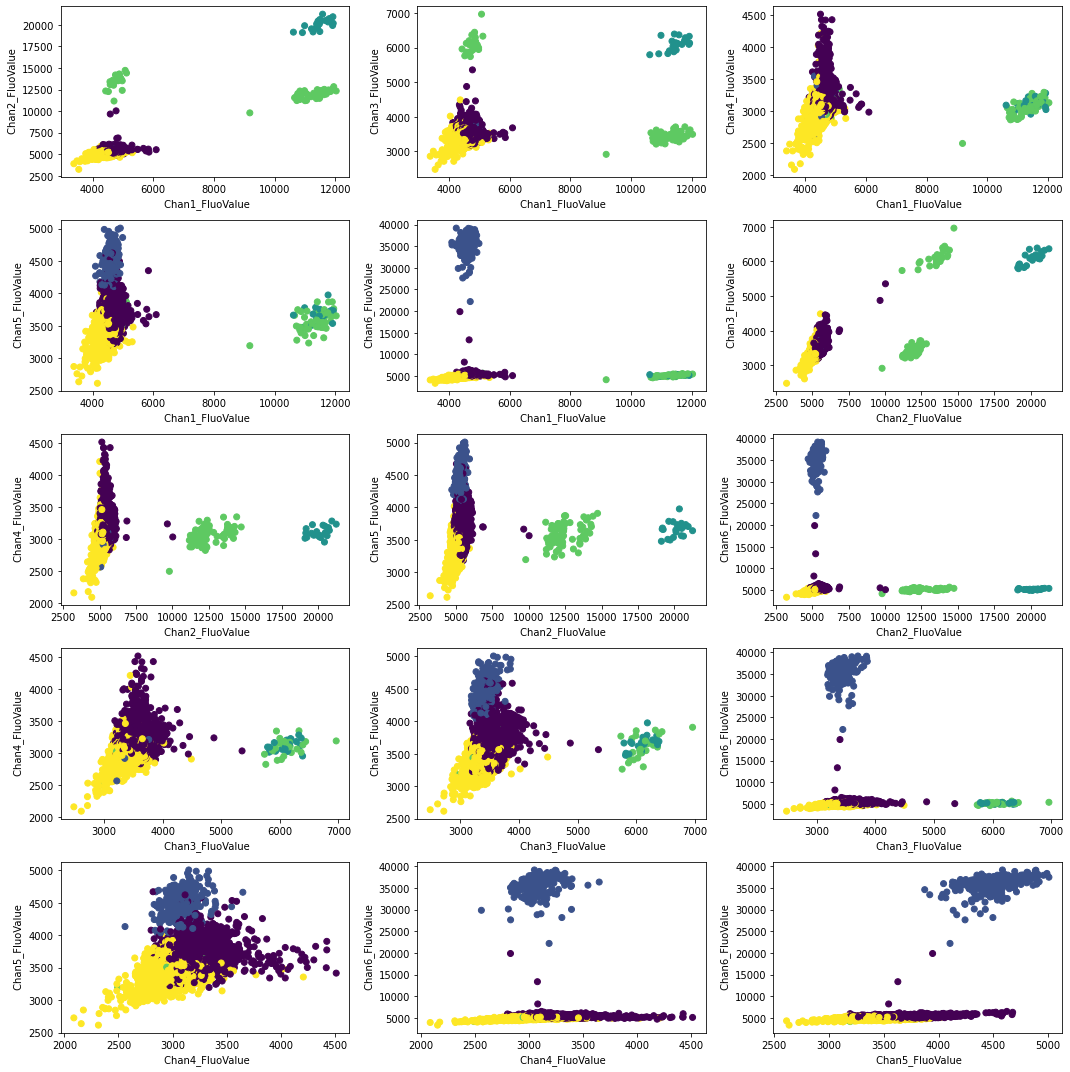

In [54]:
# num_clusters = 5
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_A3_"
df = load_dataset(file)["RawData"]
pairwise_plots_knn(df, num_clusters = 5)

We can see by looking at the data that there are 5 clusters. However, when setting 5 clusters, instead of finding the fifth cluster, it instead makes the negatives into two clusters. Why is that? I looked and the data and it is because somehow if there is fluctation in one dimension in the negative data, it is in every dimension. Hence the difference in 6 dimensions is much bigger than can be seen in the 2 dimensional plots. But probably they should still not be considered as 2 clusters.

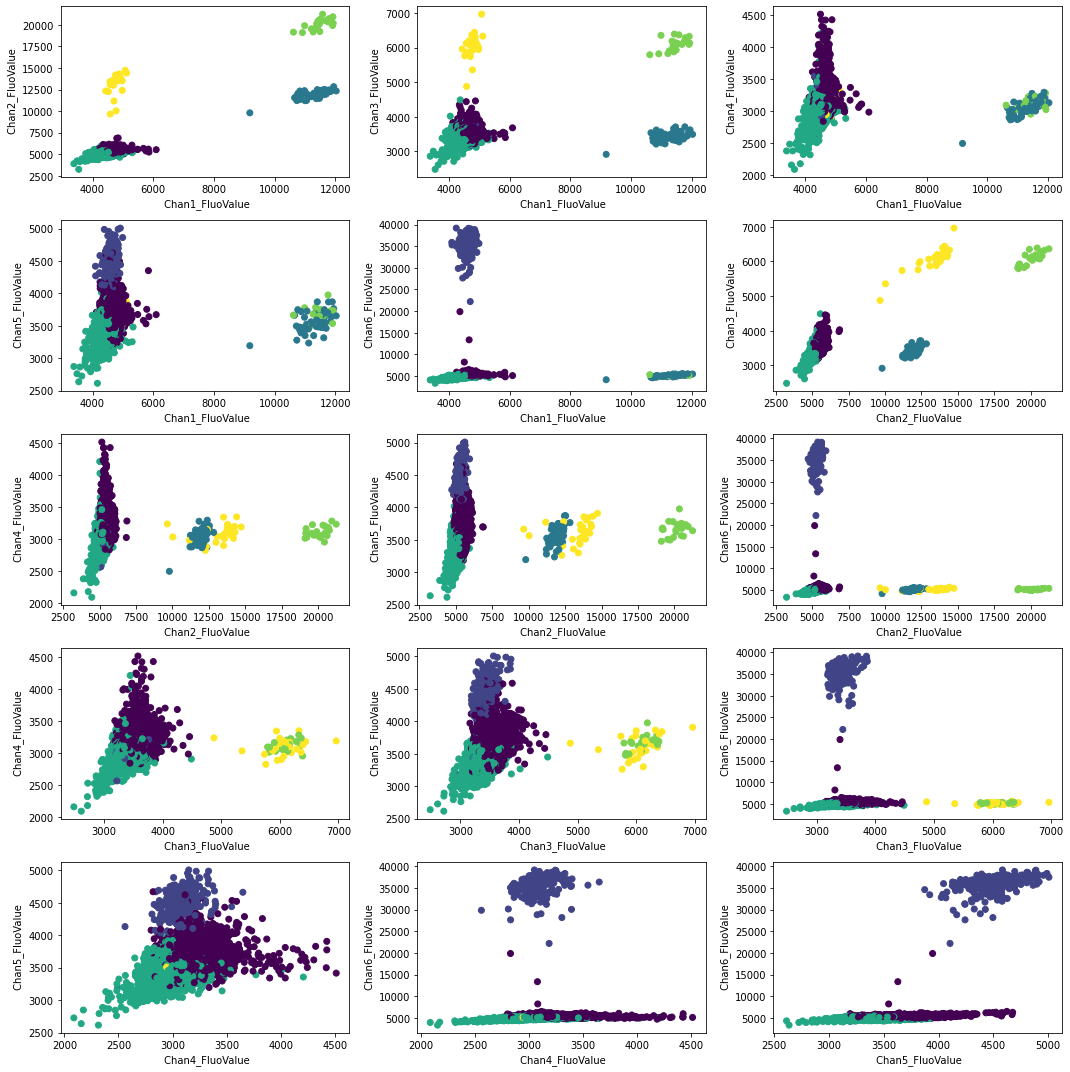

In [56]:
# num_clusters = 6
pairwise_plots_knn(df, num_clusters = 6)

By setting num_clusters = 6 we also find the last cluster!

# DB Scan

In [67]:
def pairwise_plots_dbscan(df, eps, min_samples = 5):
    np_features = df.drop(["x-coordinate_in_pixel"," y-coordinate_in_pixel"," index"], axis=1)
    np_features = np_features.to_numpy()
    classifier = cl.DBSCAN(eps = eps, min_samples = min_samples)
    preds = classifier.fit_predict(np_features)

    
    print(f"Number of outliers: {len([x for x in preds if x == -1])}") # print number of outliers
    print(f"Number of clusters: {max(preds)+1}") # print number of clusters
    
    
    combinations = itertools.combinations(df.columns[2:-1], 2)
    fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i, combination in enumerate(combinations): 
        np_features = df.loc[:, combination]
        np_features = np_features.to_numpy()

        ax[i //3, i %3].set_xlabel(combination[0])
        ax[i //3, i %3].set_ylabel(combination[1])
        ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = preds)
    fig.tight_layout()

### DB Scan on A3 Dataset

Number of outliers: 23
Number of clusters: 5


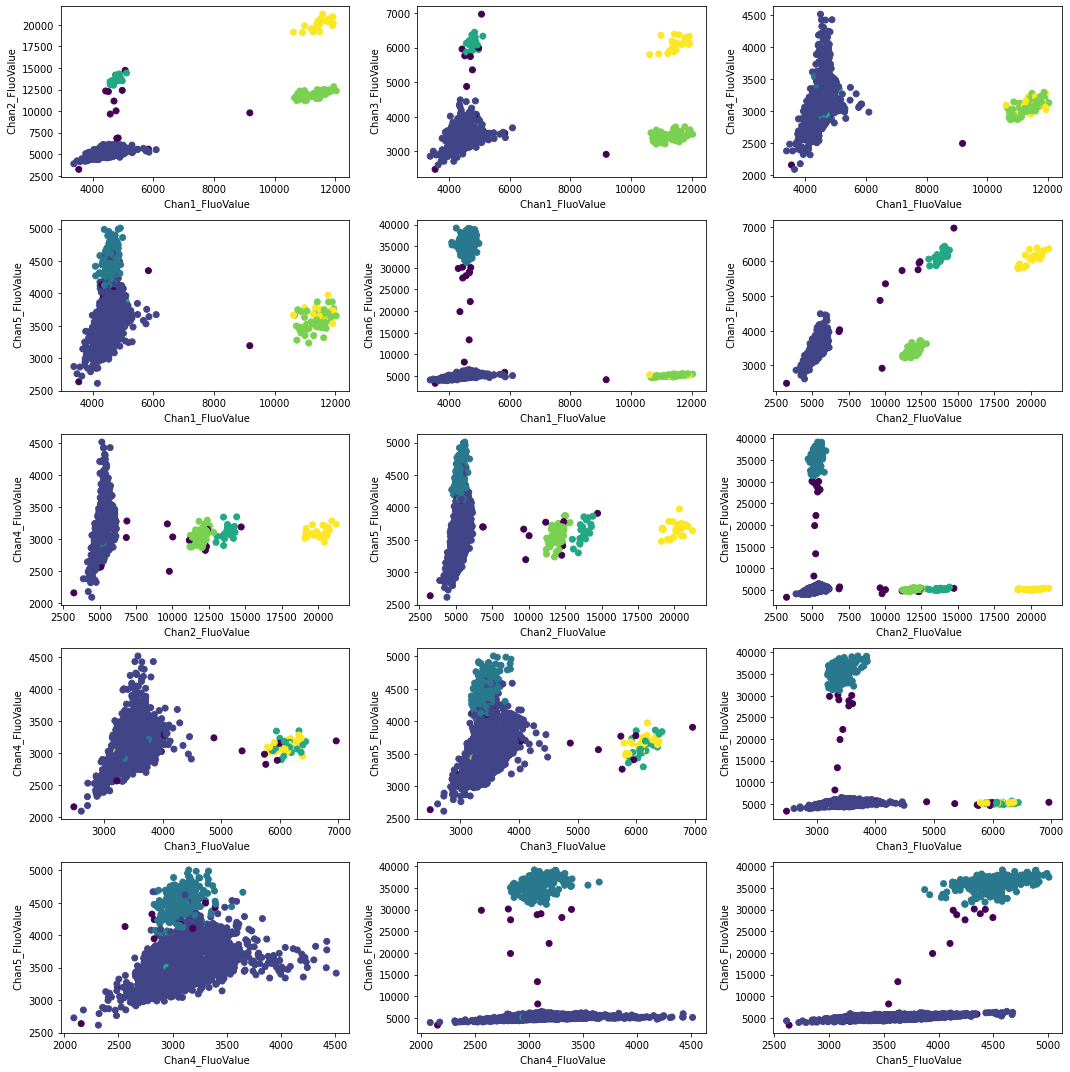

In [68]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_A3_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 5)

We see here the classification is completely correct. We even classified the outliers correctly. The only thing one might say is that a few too many points got classified as outliers, but that is debatable.

### DB Scan on B3 Dataset

Number of outliers: 27
Number of clusters: 6


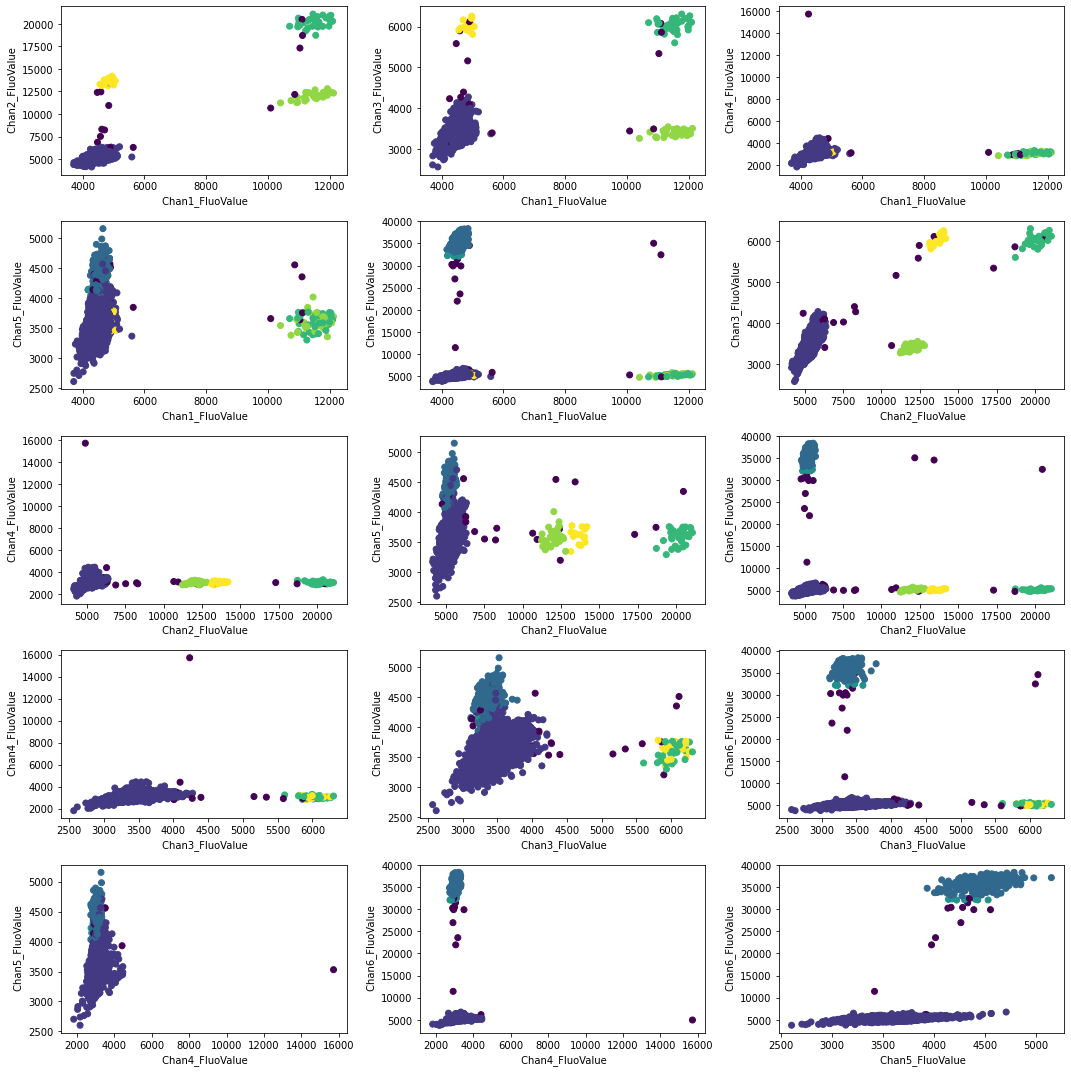

In [69]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_B3_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 5)

Here we have a very similar situation to the previous dataset, but somehow an extra cluster emerges, but this cluster has only very few points.

Number of outliers: 38
Number of clusters: 5


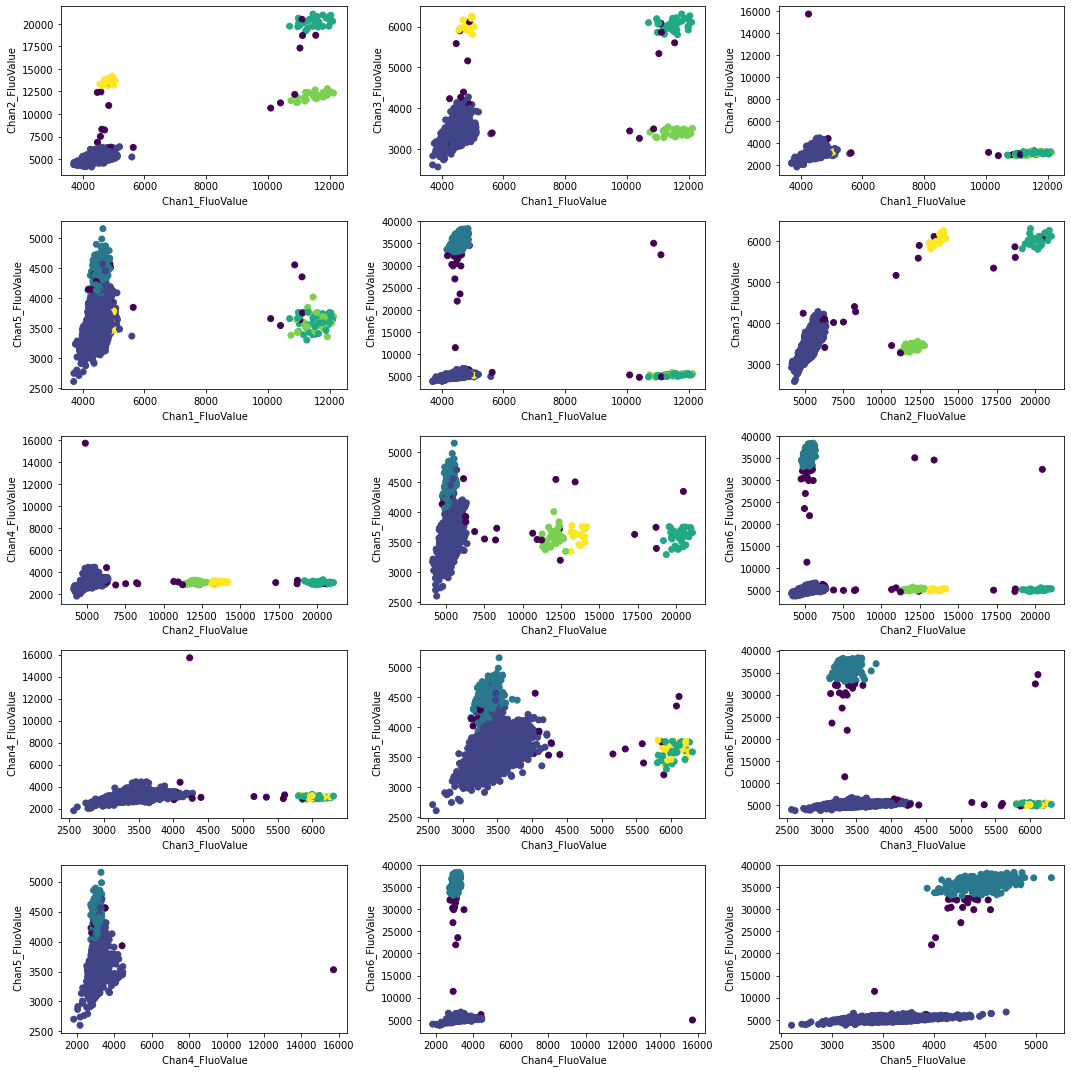

In [71]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_B3_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 10)

At the cost of increasing the number of outliers, we can also get the correct number of clusters again (this is managed by the min_samples parameter, which controls how many points a cluster needs to contain at least.)

### DB Scan on C3 Dataset

Number of outliers: 229
Number of clusters: 24


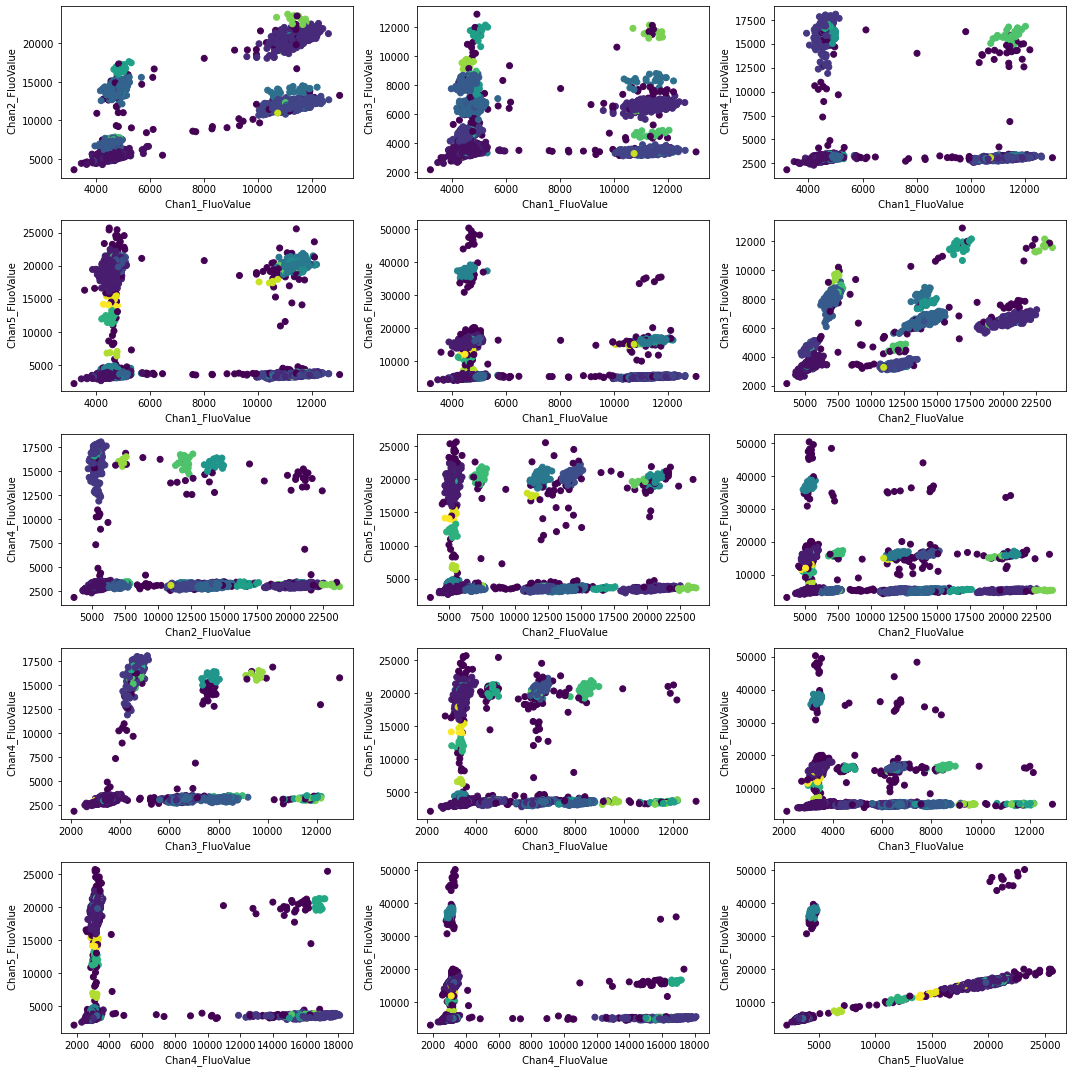

In [66]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_C3_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 5)

OOoops! This data is much more messy! We have 229 outliers and 24 clusters. The data is so complicated it is not obvious how many clusters this data actually contains. I think it would be really helpful if we had some sense of how many clusters there are (it is possible to get an estimate by doing the manual procedure in 2 dimensions just as they have done it).

I did some basic quality control checks to see if the clustering makes sense and at least it does not make obvious errors: For example, no point that has a value of more than 8000 in dimension 1 has the same label as a point that has a value of less than 8000 in dimension 1 (see the pictures to see why this makes sense and is desired). It is similar for all the other obvious separations I have checked.

### DB Scan on D3 Dataset

Number of outliers: 12
Number of clusters: 1


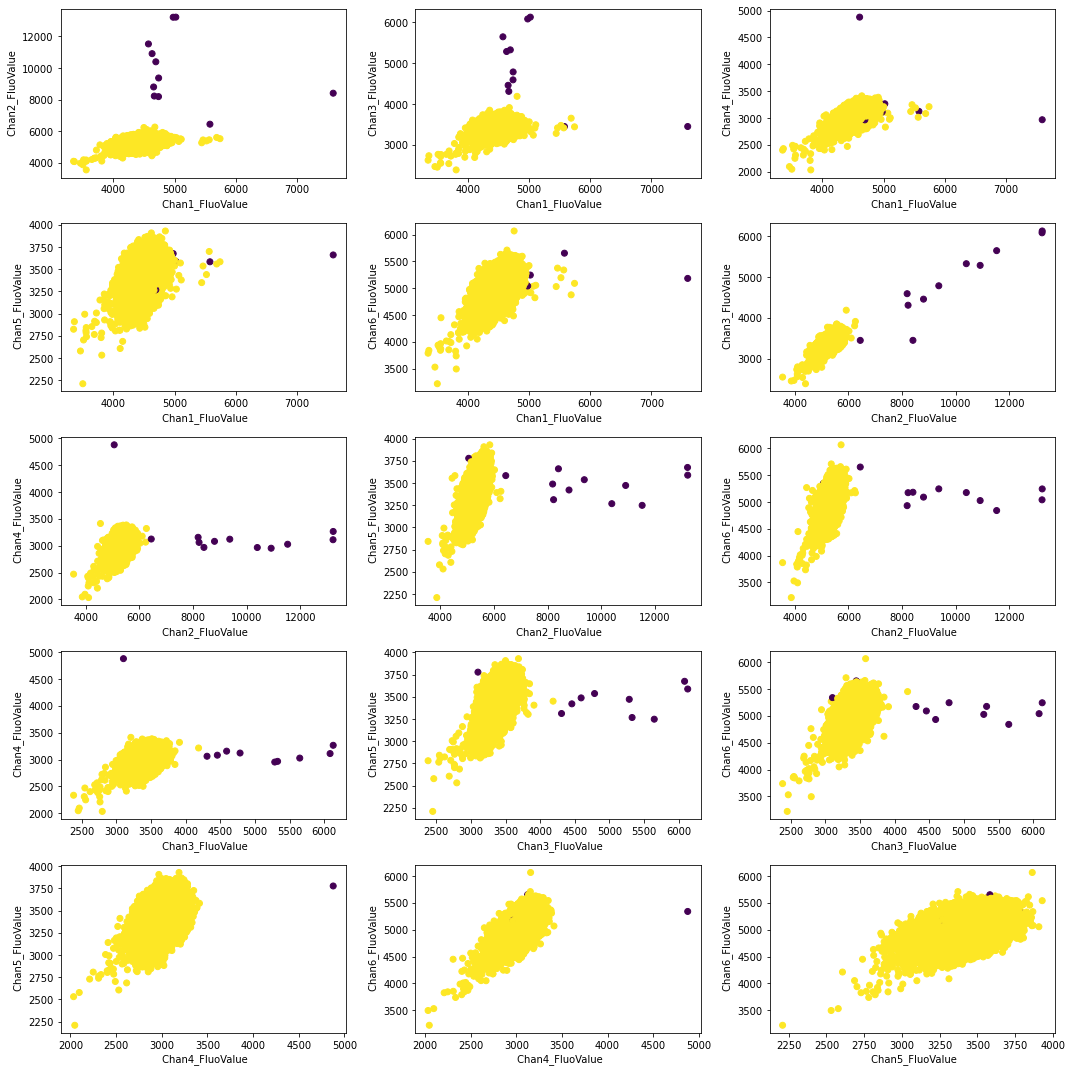

In [72]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_D3_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 5)

This data seems to be just negatives, and they are classified as so, which is desirable.

### DB Scan on A2 Dataset

Number of outliers: 43
Number of clusters: 5


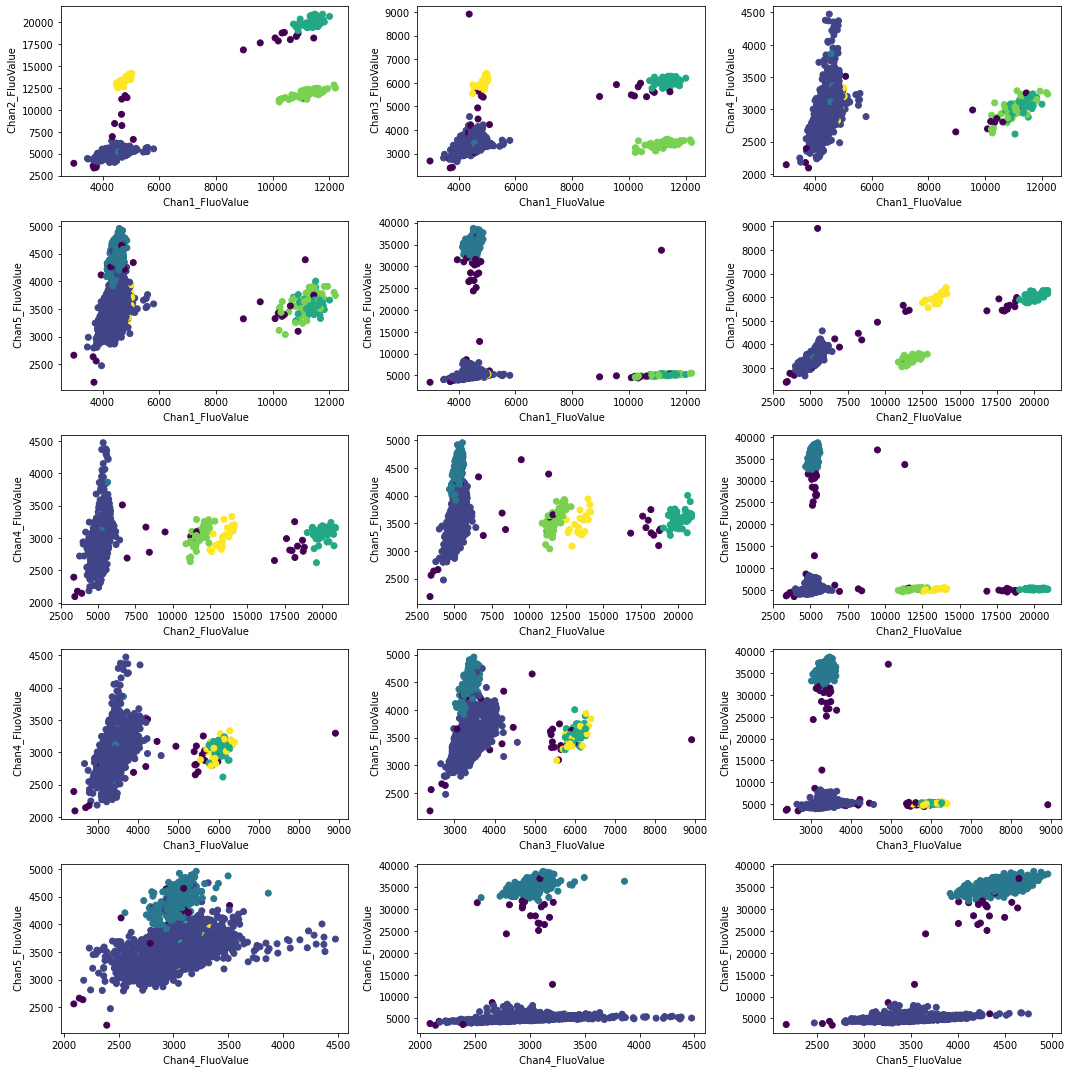

In [75]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697836-5_A2_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 10)

Also very OK clustering, though kind of a lot of outliers.

### DB Scan on B2 Dataset

Number of outliers: 34
Number of clusters: 5


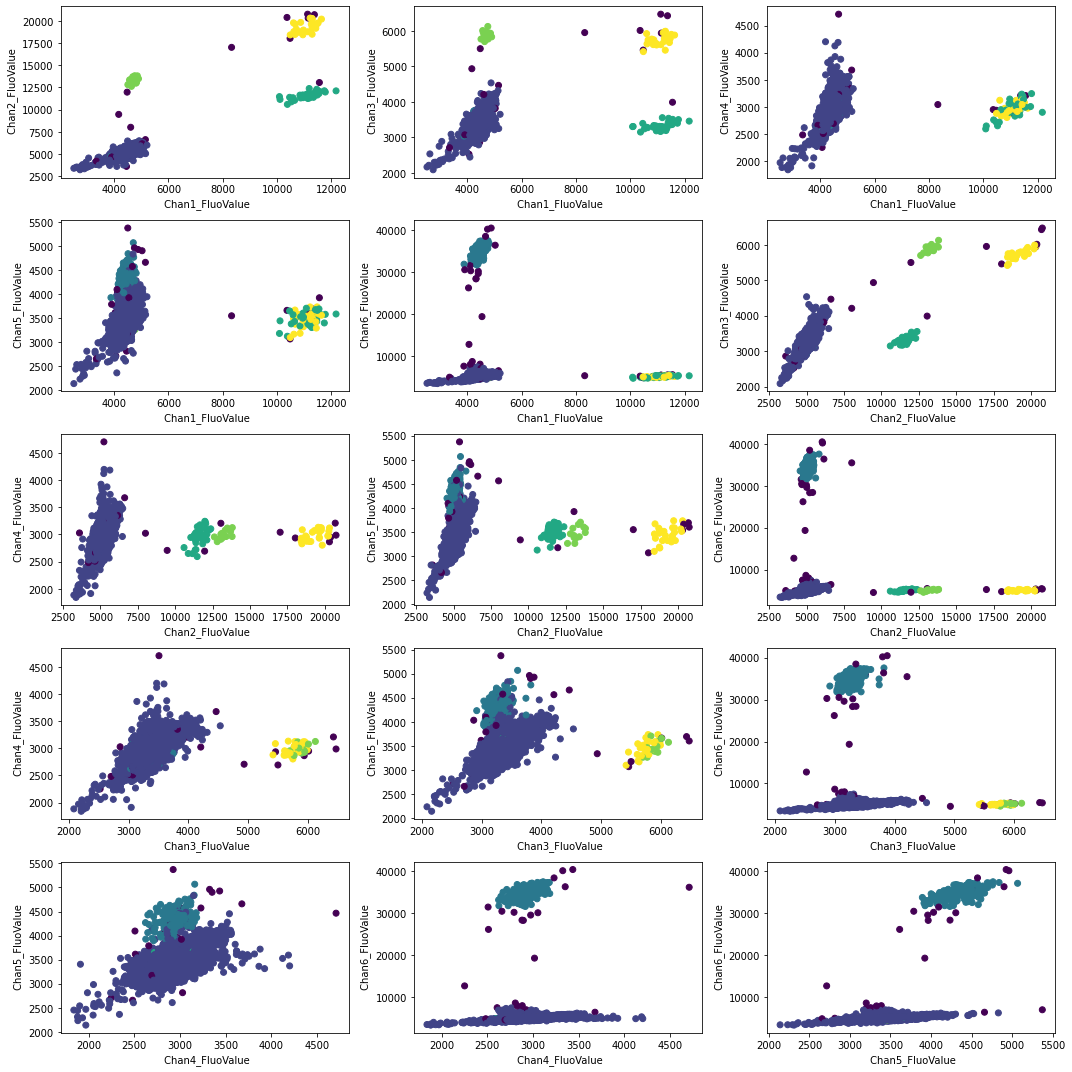

In [76]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697836-5_B2_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 10)

### DB Scan on C2 Dataset

Number of outliers: 24
Number of clusters: 4


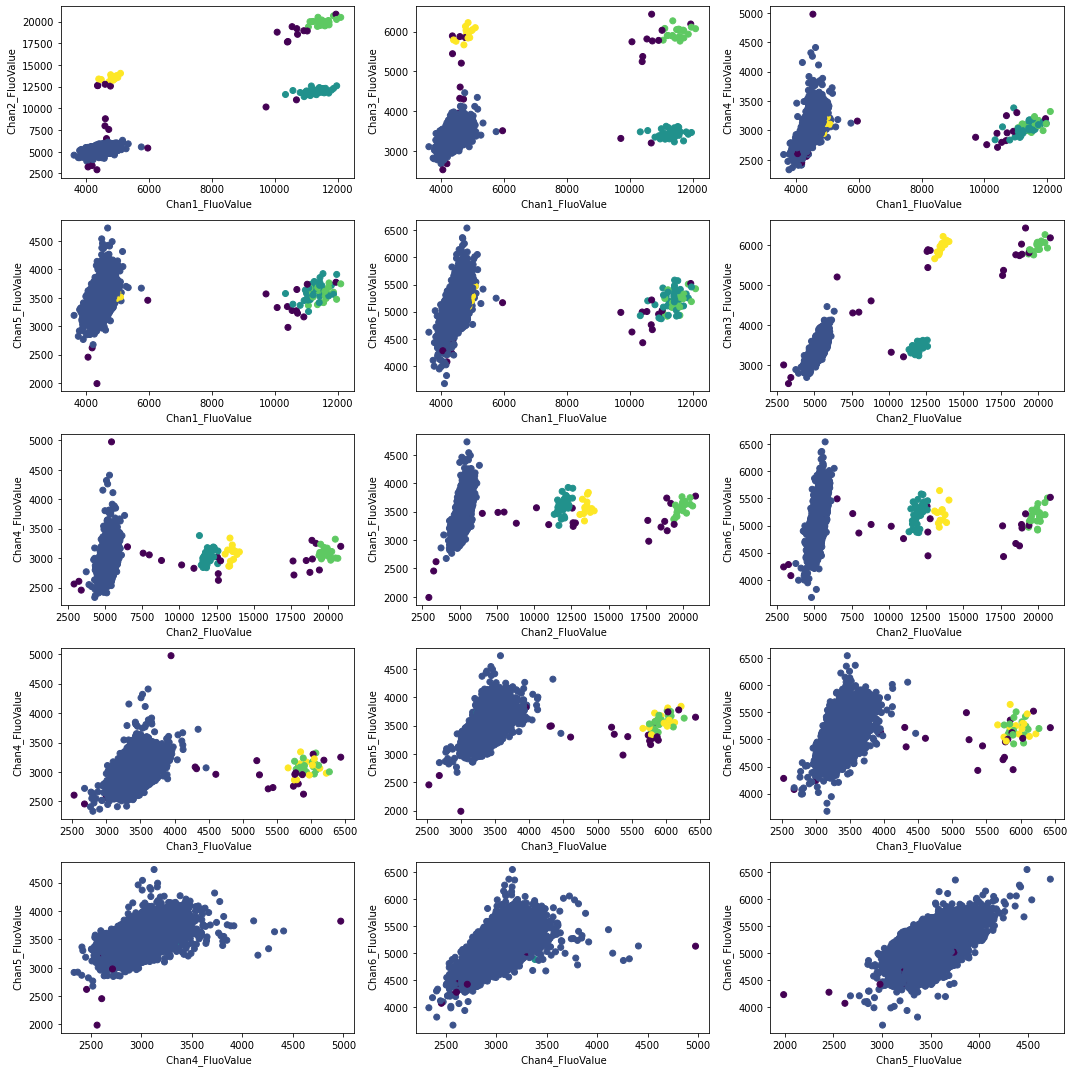

In [77]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697836-5_C2_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 10)

Interesting: First time we have only 4 clusters, but the number is again correct.

### DB Scan on D2 Dataset

Number of outliers: 22
Number of clusters: 4


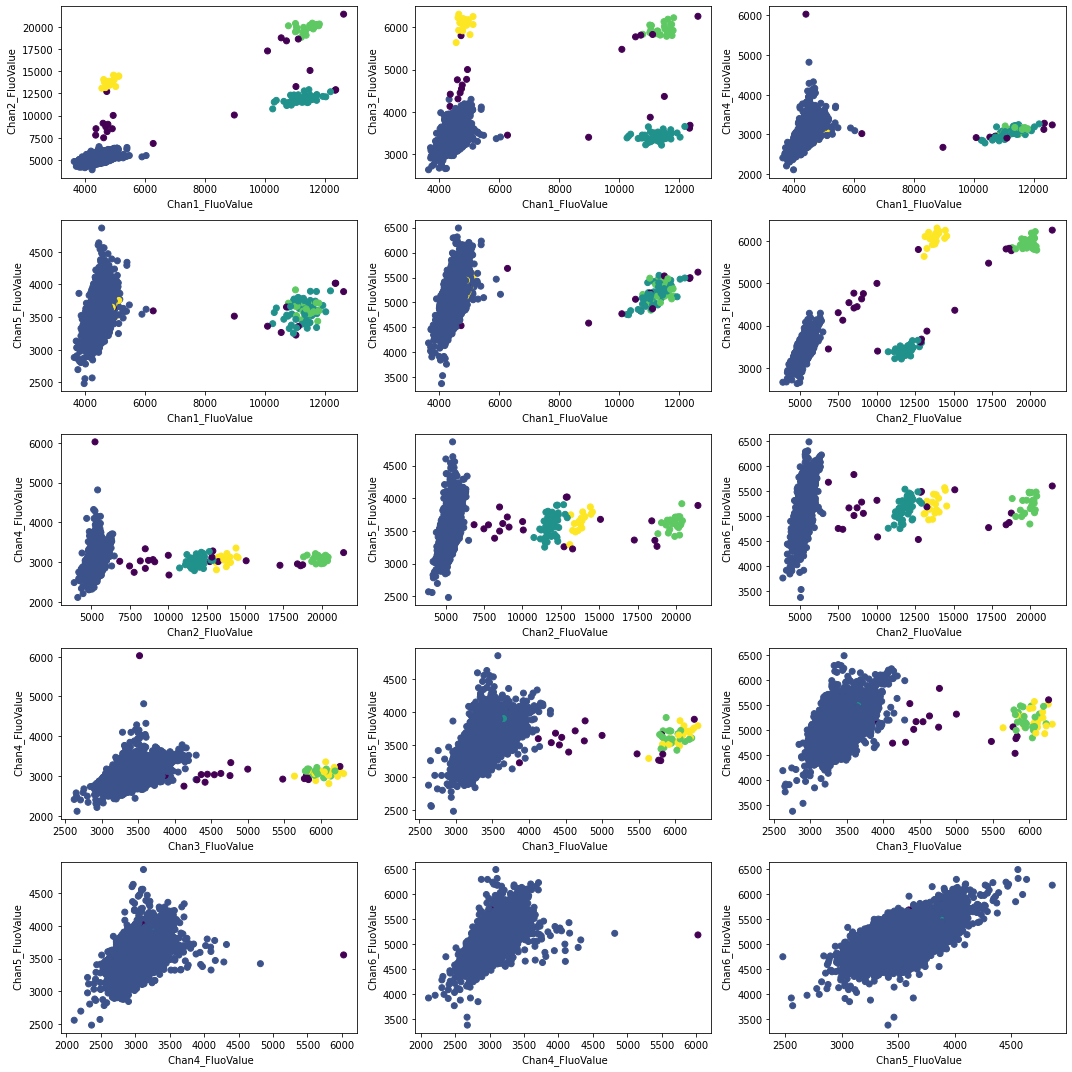

In [78]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697836-5_D2_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 10)

## Dillution Series Data

Number of outliers: 7937
Number of clusters: 77


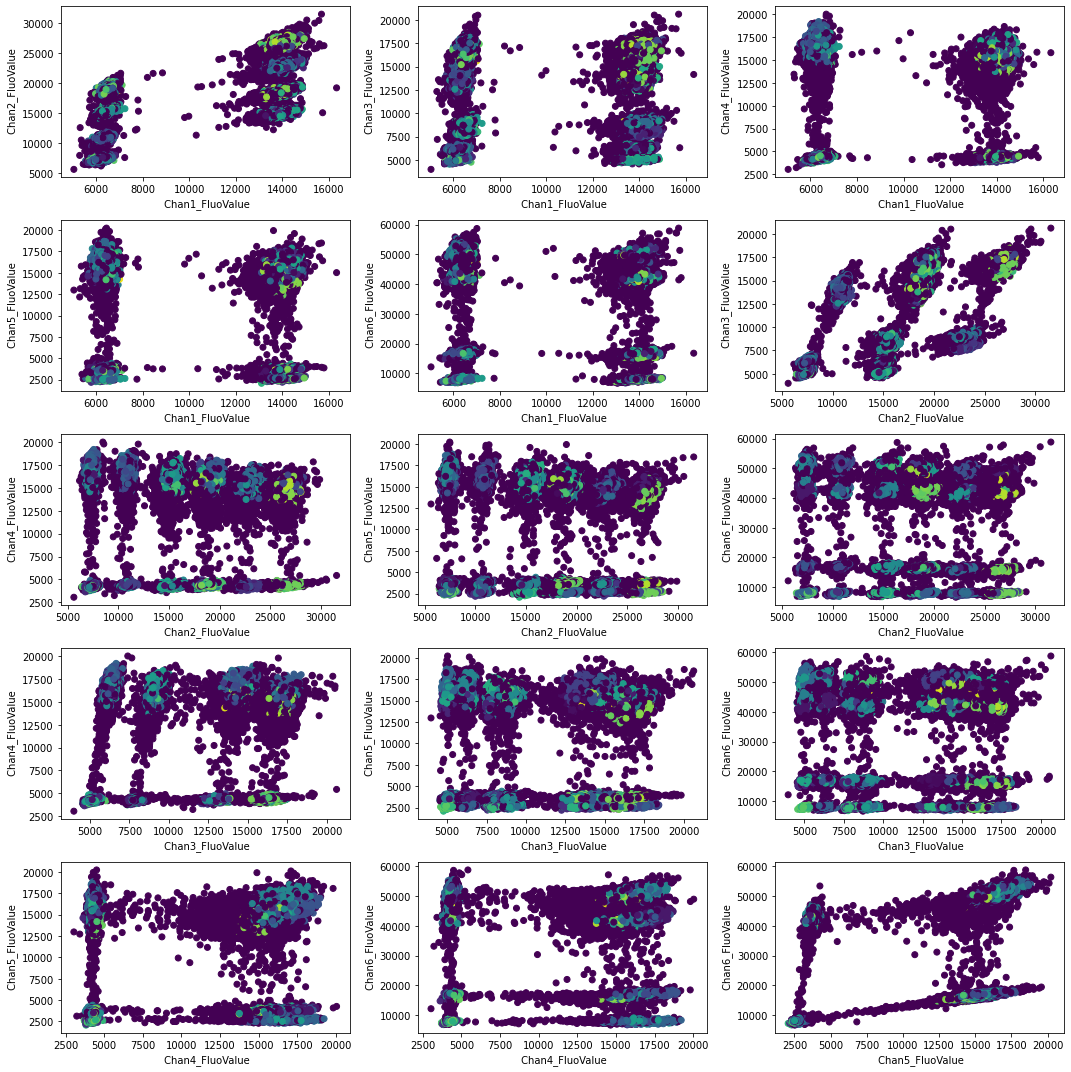

In [79]:
file = "../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData/6P-positive-dilution-series-1-labelled_S-0691366-3_A4_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 10)

WTF is going on here...??

# Remarks and Ideas to Try Out

First thing is to consider the different data we have and look whats going on there. For example with the Dillution Series Data above - what is going on?

One thing I think we need to do is to ask McLeod what the clusters will exactly be used for. As we can see from previous examples, some data may have way too many clusters, meaning that it wont be easy for us to understand what the clusters do. If we want to do classification afterwards, then why clusters at all and not just do supervised training? I guess if we just need to find out whether or not a dimension is activated or not, we can try some tricks with the clusters.

One thing I want to try out is to decorrelate the data, and then cluster the de-correlated data. We know there is quite simple linear correlation going on, so maybe decorrelation should help. In fact, I think I will try it right now and see if it takes a lot of time or not.

And then using different clustering algorithms and doing more data exploration might help a lot too!

In [91]:
file = "../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData/6P-positive-dilution-series-1-labelled_S-0691366-3_A4_"
df = load_dataset(file)["RawData"]

In [116]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)

In [126]:
eps = 0.05
min_samples = 10

np_features = df.drop(["x-coordinate_in_pixel"," y-coordinate_in_pixel"," index"], axis=1)
np_features = np_features.to_numpy()

np_features = pca.fit_transform(np_features)

classifier = cl.DBSCAN(eps = eps, min_samples = min_samples)
preds = classifier.fit_predict(np_features)


print(f"Number of outliers: {len([x for x in preds if x == -1])}") # print number of outliers
print(f"Number of clusters: {max(preds)+1}") # print number of clusters


"""combinations = itertools.combinations(df.columns[2:-1], 2)
fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, combination in enumerate(combinations): 
    np_features = df.loc[:, combination]
    np_features = np_features.to_numpy()

    ax[i //3, i %3].set_xlabel(combination[0])
    ax[i //3, i %3].set_ylabel(combination[1])
    ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = preds)
fig.tight_layout()"""

Number of outliers: 25348
Number of clusters: 8


'combinations = itertools.combinations(df.columns[2:-1], 2)\nfig, ax = plt.subplots(5, 3, sharex=False, sharey=False)\nfig.set_figheight(15)\nfig.set_figwidth(15)\nfor i, combination in enumerate(combinations): \n    np_features = df.loc[:, combination]\n    np_features = np_features.to_numpy()\n\n    ax[i //3, i %3].set_xlabel(combination[0])\n    ax[i //3, i %3].set_ylabel(combination[1])\n    ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = preds)\nfig.tight_layout()'

need to look further into how to decorrelate properly.